* First we import required libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')
from bs4 import BeautifulSoup
import re
from tqdm import tqdm

Libraries imported.


* We will now define a function to scrape data from webpage and convert to DataFrame

In [2]:
def reads(soup):
    street=[]
    area=[]
    postalcode=[]
    price=[]
    price=[i.text for i in soup.find_all('div',class_='prop-list-head-price')]
    location=[i.text for i in soup.find_all('div',class_='prop-list-body-address col-md-12')]
    for j in location:
        street.append(j.split(',')[0])
        area.append(j.split(',')[1])
        postalcode.append(j.split(',')[2])
    return pd.DataFrame({'Postal Code':postalcode,'Area':area,'Street':street,"Price":price})

* Code to access pages one by one and append scraped DataFrames to list

In [3]:
data=[]
stubs='https://www.your-move.co.uk/flats-to-rent/london/!/location/london~40/page/{}'
for i in tqdm(range(1,12)):
    url=stubs.format(i)
    html=requests.get(url).text
    soup=BeautifulSoup(html)
    data.append(reads(soup))

100%|██████████| 11/11 [00:13<00:00,  1.21s/it]


* Converting list to DataFrame

In [4]:
df=pd.concat(data,axis=0)

In [5]:
df.head(10)

,Postal Code,Area,Street,Price
0,DA14,Sidcup,Frognal Avenue,"£3,593 pcm"
1,DA14,Sidcup,Frognal Avenue,"£3,176 pcm"
2,SE10,London,Cutter Lane Chandlers Avenue,"£2,990 pcm"
3,SE10,London,Telcon Way,"£2,400 pcm"
4,SE5,London,Lettsom Street,"£2,150 pcm"
5,BR1,Bromley,Plaistow Lane,"£2,100 pcm"
6,TW20,Egham,The Hub Stoneylands Road,"£2,000 pcm"
7,TW20,Egham,Egham Hill,"£1,950 pcm"
8,SE14,London,Childeric Road,"£1,900 pcm"
9,BN1,Brighton,Hollingdean Terrace,"£1,820 pcm"


In [6]:
df.head(20)

,Postal Code,Area,Street,Price
0,DA14,Sidcup,Frognal Avenue,"£3,593 pcm"
1,DA14,Sidcup,Frognal Avenue,"£3,176 pcm"
2,SE10,London,Cutter Lane Chandlers Avenue,"£2,990 pcm"
3,SE10,London,Telcon Way,"£2,400 pcm"
4,SE5,London,Lettsom Street,"£2,150 pcm"
5,BR1,Bromley,Plaistow Lane,"£2,100 pcm"
6,TW20,Egham,The Hub Stoneylands Road,"£2,000 pcm"
7,TW20,Egham,Egham Hill,"£1,950 pcm"
8,SE14,London,Childeric Road,"£1,900 pcm"
9,BN1,Brighton,Hollingdean Terrace,"£1,820 pcm"


## DATA CLEANING

In [7]:
df.reset_index(drop=True,inplace=True)

* Converting String numbers to Int

In [8]:
df['Raw_Price']=df['Price'].apply(lambda x:x.replace('£','').split()[0])

In [9]:
df['Raw_Price']=df['Raw_Price'].apply(lambda x:int(x.replace(',','')))

In [10]:
df.head()

,Postal Code,Area,Street,Price,Raw_Price
0,DA14,Sidcup,Frognal Avenue,"£3,593 pcm",3593
1,DA14,Sidcup,Frognal Avenue,"£3,176 pcm",3176
2,SE10,London,Cutter Lane Chandlers Avenue,"£2,990 pcm",2990
3,SE10,London,Telcon Way,"£2,400 pcm",2400
4,SE5,London,Lettsom Street,"£2,150 pcm",2150


* Filtering out values based on location (Here we only access major areas in London for which data is available)

In [11]:
new_df=df[df['Area'].str.contains('London|Sidcup|Bromley|Barking|Romford')]

In [12]:
new_df.head()

,Postal Code,Area,Street,Price,Raw_Price
0,DA14,Sidcup,Frognal Avenue,"£3,593 pcm",3593
1,DA14,Sidcup,Frognal Avenue,"£3,176 pcm",3176
2,SE10,London,Cutter Lane Chandlers Avenue,"£2,990 pcm",2990
3,SE10,London,Telcon Way,"£2,400 pcm",2400
4,SE5,London,Lettsom Street,"£2,150 pcm",2150


* Cleaning data by dropping duplicate postal codes and dropping weekly rent areas

In [13]:
new_df = new_df[~new_df["Price"].str.contains('Weekly')]

In [14]:
new_df.drop_duplicates(subset='Postal Code', keep='first', inplace=True)

In [15]:
new_df.reset_index(drop=True,inplace=True)

In [16]:
new_df

,Postal Code,Area,Street,Price,Raw_Price
0,DA14,Sidcup,Frognal Avenue,"£3,593 pcm",3593
1,SE10,London,Cutter Lane Chandlers Avenue,"£2,990 pcm",2990
2,SE5,London,Lettsom Street,"£2,150 pcm",2150
3,BR1,Bromley,Plaistow Lane,"£2,100 pcm",2100
4,SE14,London,Childeric Road,"£1,900 pcm",1900
5,E11,London,New Wanstead,"£1,800 pcm",1800
6,SW15,London,Sherfield Gardens,"£1,600 pcm",1600
7,SE4,London,Adelaide Avenue,"£1,450 pcm",1450
8,E7,London,Disraeli Road,"£1,400 pcm",1400
9,IG11,Barking,East Street,"£1,400 pcm",1400


### Latitude and Longitude values for each postal code is collected from https://www.doogal.co.uk/

In [17]:
latlong=[(51.426481,0.105038),(51.487122,0.003284),(51.481796,-0.090377),(51.401546,0.015415),(51.450352,0.062336),(51.474867,-0.046933),(51.564032,0.008813),(51.464123,-0.222848),(51.453268,-0.032498),(51.554412,0.019655),(51.524785,0.078646),(51.491797,-0.042421),(51.429347,-0.044847),(51.407775,-0.003321),(51.434204,-0.085226),(51.47681,-0.068163),(51.492037,0.087067),(51.467676,0.018169),(51.53758,0.040295),(51.484461,0.084733),(51.5776,0.178261),(51.585503,-0.018014),(51.577913,0.190919)]

In [18]:
lat=[]
ln=[]
for i in latlong:
    lat.append(i[0])
    ln.append(i[1])
    

* Now we add Latitude and Longitude values to existing DataFrame

In [19]:
new_df['Latitude']=lat
new_df['Longitude']=ln

In [20]:
new_df

,Postal Code,Area,Street,Price,Raw_Price,Latitude,Longitude
0,DA14,Sidcup,Frognal Avenue,"£3,593 pcm",3593,51.426481,0.105038
1,SE10,London,Cutter Lane Chandlers Avenue,"£2,990 pcm",2990,51.487122,0.003284
2,SE5,London,Lettsom Street,"£2,150 pcm",2150,51.481796,-0.090377
3,BR1,Bromley,Plaistow Lane,"£2,100 pcm",2100,51.401546,0.015415
4,SE14,London,Childeric Road,"£1,900 pcm",1900,51.450352,0.062336
5,E11,London,New Wanstead,"£1,800 pcm",1800,51.474867,-0.046933
6,SW15,London,Sherfield Gardens,"£1,600 pcm",1600,51.564032,0.008813
7,SE4,London,Adelaide Avenue,"£1,450 pcm",1450,51.464123,-0.222848
8,E7,London,Disraeli Road,"£1,400 pcm",1400,51.453268,-0.032498
9,IG11,Barking,East Street,"£1,400 pcm",1400,51.554412,0.019655


* Let's take our data in a new DataFrame ld_data

In [21]:
ld_data=new_df

In [22]:
ld_data.rename(columns={'Street':'Neighborhood','Area':'City'},inplace=True)

In [23]:
ld_data

,Postal Code,City,Neighborhood,Price,Raw_Price,Latitude,Longitude
0,DA14,Sidcup,Frognal Avenue,"£3,593 pcm",3593,51.426481,0.105038
1,SE10,London,Cutter Lane Chandlers Avenue,"£2,990 pcm",2990,51.487122,0.003284
2,SE5,London,Lettsom Street,"£2,150 pcm",2150,51.481796,-0.090377
3,BR1,Bromley,Plaistow Lane,"£2,100 pcm",2100,51.401546,0.015415
4,SE14,London,Childeric Road,"£1,900 pcm",1900,51.450352,0.062336
5,E11,London,New Wanstead,"£1,800 pcm",1800,51.474867,-0.046933
6,SW15,London,Sherfield Gardens,"£1,600 pcm",1600,51.564032,0.008813
7,SE4,London,Adelaide Avenue,"£1,450 pcm",1450,51.464123,-0.222848
8,E7,London,Disraeli Road,"£1,400 pcm",1400,51.453268,-0.032498
9,IG11,Barking,East Street,"£1,400 pcm",1400,51.554412,0.019655


* Using geolocator we can obtain the geographical coordinates of London:

In [24]:
address='London, UK'
geolocator=Nominatim(user_agent="ld_explorer")
location= geolocator.geocode(address)
latitude=location.latitude
longitude=location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


## FOLIUM
* Folium is a very powerful mapping tool which we will be using to plot our latitude and longitude values of each neighborhood on the geographical map of London

In [25]:
map_ld=folium.Map(location=[latitude,longitude],zoom_start=10)

for lat,lng,city,neighborhood in zip(ld_data["Latitude"],ld_data["Longitude"],ld_data["City"],ld_data["Neighborhood"]):
    label='{}{}'.format(neighborhood,city)
    label=folium.Popup(label,parse_html=True)
    folium.Circle([lat,lng],radius=1000,color='blue',popup=label,fill=True,fill_color='#3186cc',fill_opacity=0.7,parse_html=False).add_to(map_ld)
map_ld


## Let us begin the exploration of our neighborhoods

# FOURSQUARE API
* All data regarding venues in our neighborhood can be collected from the Foursquare API
* We begin by initialisisng our credentials

In [26]:
CLIENT_ID = 'G5XELWRC2EMZHYGGKF20VTKEWZE3GSGFBAQZNG4NUYHKVHQT' # your Foursquare ID
CLIENT_SECRET = 'GKBXNMTGJTWF04VMQVCNDYG5WR4UCRFTQTA2VXFLKF1JIQAX' # your Foursquare Secret
ACCESS_TOKEN = 'BOLQGFEKLU1E0CTOOSVPC5SSUTRQSWPXZHYSYMNB4V33DE5C' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 100

In [27]:
ld_data.loc[0,:]

Postal Code               DA14
City                    Sidcup
Neighborhood    Frognal Avenue
Price               £3,593 pcm
Raw_Price                 3593
Latitude               51.4265
Longitude             0.105038
Name: 0, dtype: object

In [28]:
neighborhood_longitude=ld_data.loc[0,'Longitude']
neighborhood_latitude=ld_data.loc[0,'Latitude']
neighborhood_name=ld_data.loc[0,'Neighborhood']
print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Frognal Avenue are 51.426481, 0.105038.


* We call the FourSquare API by intialising the URL with our credentials and required neighborhood location

In [29]:
limit=100
radius=500
url='https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&r={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=G5XELWRC2EMZHYGGKF20VTKEWZE3GSGFBAQZNG4NUYHKVHQT&client_secret=GKBXNMTGJTWF04VMQVCNDYG5WR4UCRFTQTA2VXFLKF1JIQAX&v=20180604&ll=51.426481,0.105038&r=500&limit=100'

* The URL data can be accessed using requests package.
* The data, which is in json format will be converted to a DataFrame

In [30]:
venues=requests.get(url).json()['response']['groups'][0]['items']

In [31]:
import json
from pandas import json_normalize # tranform JSON file into a pandas dataframe
nearby_venues=json_normalize(venues).head()

In [32]:
nearby_venues

,referralId,reasons.count,reasons.items,venue.id,venue.name,venue.location.address,venue.location.lat,venue.location.lng,venue.location.labeledLatLngs,venue.location.distance,venue.location.postalCode,venue.location.cc,venue.location.city,venue.location.state,venue.location.country,venue.location.formattedAddress,venue.categories,venue.photos.count,venue.photos.groups,venue.venuePage.id,venue.location.neighborhood,venue.location.crossStreet,venue.events.count,venue.events.summary
0,e-0-4c77cba1923ba143c31668e6-0,0,"[{'summary': 'This spot is popular', 'type': '...",4c77cba1923ba143c31668e6,Caffè Nero,89 High St,51.426425,0.101383,"[{'label': 'display', 'lat': 51.4264249272159,...",253,DA14 6DJ,GB,Sidcup,Greater London,United Kingdom,"[89 High St, Sidcup, Greater London, DA14 6DJ,...","[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",0,[],NaN,NaN,NaN,NaN,NaN
1,e-0-572e2bbe498efaf0028dd0d4-1,0,"[{'summary': 'This spot is popular', 'type': '...",572e2bbe498efaf0028dd0d4,Hello Burger,94 Station Rd,51.431988,0.102496,"[{'label': 'display', 'lat': 51.431988, 'lng':...",637,NaN,GB,Sidcup,Greater London,United Kingdom,"[94 Station Rd, Sidcup, Greater London, United...","[{'id': '4bf58dd8d48988d16c941735', 'name': 'B...",0,[],483501337,NaN,NaN,NaN,NaN
2,e-0-4fe5e2cde4b010f80e3b9c02-2,0,"[{'summary': 'This spot is popular', 'type': '...",4fe5e2cde4b010f80e3b9c02,Walnuts,Main Rd,51.426534,0.099790,"[{'label': 'display', 'lat': 51.42653400193202...",364,DA14 6ND,GB,Sidcup,Greater London,United Kingdom,"[Main Rd, Sidcup, Greater London, DA14 6ND, Un...","[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",0,[],NaN,NaN,NaN,NaN,NaN
3,e-0-522763b911d2b7710f27f9ad-3,0,"[{'summary': 'This spot is popular', 'type': '...",522763b911d2b7710f27f9ad,Little Waitrose & Partners,1-3 High Street,51.425139,0.105604,"[{'label': 'display', 'lat': 51.42513884112205...",154,DA14 6EN,GB,Sidcup,Greater London,United Kingdom,"[1-3 High Street, Sidcup, Greater London, DA14...","[{'id': '4bf58dd8d48988d118951735', 'name': 'G...",0,[],NaN,NaN,NaN,NaN,NaN
4,e-0-4bd43007462cb71349d2df07-4,0,"[{'summary': 'This spot is popular', 'type': '...",4bd43007462cb71349d2df07,Scadbury Park Nature Reserve,Old Perry St,51.414371,0.087568,"[{'label': 'display', 'lat': 51.41437115383853...",1813,BR7 6LS,GB,Chislehurst,Greater London,United Kingdom,"[Old Perry St, Chislehurst, Greater London, BR...","[{'id': '52e81612bcbc57f1066b7a13', 'name': 'N...",0,[],NaN,NaN,NaN,NaN,NaN


* Formatting the DataFrame containing venue data and filtering out unnecessary information

In [33]:
filtered_columns=['venue.name','venue.categories','venue.location.lat','venue.location.lng']

In [34]:
nearby_venues =nearby_venues.loc[:, filtered_columns]

In [35]:
nearby_venues['venue.categories']=nearby_venues['venue.categories'].apply(lambda x:x[0]['name'])

In [36]:
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Caffè Nero,Coffee Shop,51.426425,0.101383
1,Hello Burger,Burger Joint,51.431988,0.102496
2,Walnuts,Café,51.426534,0.099790
3,Little Waitrose & Partners,Grocery Store,51.425139,0.105604
4,Scadbury Park Nature Reserve,Nature Preserve,51.414371,0.087568


In [37]:
nearby_venues.columns=[col.split('.')[-1] for col in nearby_venues.columns]

* Let's check how many venues where provided by the FourSquare API

In [38]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

5 venues were returned by Foursquare.


### getNearbyVenues()
* Now we define a function which will give us venues for each neighborhood name and location we provide

In [39]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

* Feed neighborhood data to the function to get venues

In [40]:
ld_venues = getNearbyVenues(names=ld_data['Neighborhood'],
                                   latitudes=ld_data['Latitude'],
                                   longitudes=ld_data['Longitude'])

Frognal Avenue
Cutter Lane Chandlers Avenue
Lettsom Street
Plaistow Lane
Childeric Road
New Wanstead
Sherfield Gardens
Adelaide Avenue
Disraeli Road
East Street
Jamaica Road
Sydenham Road
Sandford Road
Kingswood Estate
Shurland Gardens Willowbrook Estate
Anson Place
Grove Place
Coleraine Road
High Street South
South Street
Elmley Street
Hoe Street
Kidman Close


* Complete list of venues in each neighborhood

In [41]:
ld_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Frognal Avenue,51.426481,0.105038,Little Waitrose & Partners,51.425139,0.105604,Grocery Store
1,Frognal Avenue,51.426481,0.105038,Caffè Nero,51.426425,0.101383,Coffee Shop
2,Frognal Avenue,51.426481,0.105038,Walnuts,51.426534,0.099790,Café
3,Frognal Avenue,51.426481,0.105038,PizzaExpress,51.426307,0.100260,Pizza Place
4,Frognal Avenue,51.426481,0.105038,Greggs,51.426142,0.103214,Bakery


* Let's check how many venues each neighborhood has

In [42]:
venue_counts=ld_venues.groupby('Neighborhood')['Venue Category'].count()

In [43]:
print('There are {} uniques categories.'.format(len(ld_venues['Venue Category'].unique())))


There are 117 uniques categories.


# One-Hot Encoding
*Before we can apply K-Means, it is necessay for us to encode our categorical data using the One-Hot Encoding technique

In [44]:
ld_onehot=pd.get_dummies(ld_venues['Venue Category'])

In [45]:
ld_onehot['Neighborhood'] = ld_venues['Neighborhood'] 

* Moving newly added Neighborhood column to the beginning of the DataFrame

In [46]:
fixed_columns = [ld_onehot.columns[-1]] + list(ld_onehot.columns[0:-1])
ld_onehot = ld_onehot[fixed_columns]

In [47]:
ld_onehot.head()

,Neighborhood,American Restaurant,Asian Restaurant,Athletics & Sports,Australian Restaurant,Bakery,Bar,Beer Store,Betting Shop,Bookstore,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Building,Burger Joint,Bus Station,Bus Stop,Café,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dim Sum Restaurant,Diner,Discount Store,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flower Shop,Food Truck,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gastropub,Gelato Shop,Gift Shop,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Health Food Store,Hobby Shop,Home Service,Hotel,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Kebab Restaurant,Locksmith,Malay Restaurant,Market,Mediterranean Restaurant,Metro Station,Middle Eastern Restaurant,Mobile Phone Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Newsstand,Optical Shop,Park,Pharmacy,Pie Shop,Pier,Pizza Place,Platform,Plaza,Portuguese Restaurant,Post Office,Pub,Recording Studio,Recreation Center,Restaurant,Sandwich Place,Shopping Mall,Soccer Field,South American Restaurant,South Indian Restaurant,Sporting Goods Shop,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Train Station,Turkish Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,Frognal Avenue,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Frognal Avenue,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Frognal Avenue,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Frognal Avenue,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Frognal Avenue,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


* Check the shape after encoding

In [48]:
ld_onehot.shape

(456, 118)

# TOP 10 VENUES
* Now we can list out the top 10 venues for each neighborhood based on frequency of occurrence

In [49]:
ld_grouped=ld_onehot.groupby('Neighborhood').mean().reset_index()

* Top 5 venues for each neighborhood

In [50]:
num_top_venues = 5

for hood in ld_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = ld_grouped[ld_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide Avenue----
                 venue  freq
0          Coffee Shop  0.16
1                  Pub  0.11
2                 Café  0.07
3       Clothing Store  0.07
4  Japanese Restaurant  0.07


----Anson Place----
            venue  freq
0        Bus Stop  0.15
1   Grocery Store  0.10
2             Pub  0.10
3  Discount Store  0.10
4            Park  0.10


----Childeric Road----
                      venue  freq
0  Mediterranean Restaurant  0.14
1                       Pub  0.07
2               Supermarket  0.07
3      Gym / Fitness Center  0.07
4             Movie Theater  0.07


----Cutter Lane Chandlers Avenue----
                venue  freq
0       Grocery Store  0.16
1                Pier  0.10
2                 Pub  0.10
3   Indian Restaurant  0.06
4  Turkish Restaurant  0.06


----Disraeli Road----
                venue  freq
0         Coffee Shop  0.12
1       Grocery Store  0.06
2               Diner  0.06
3        Gourmet Shop  0.06
4  Chinese Restaurant  0.06


----Ea

In [51]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

* DataFrame with top 10 Venues

In [52]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = ld_grouped['Neighborhood']

for ind in np.arange(ld_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ld_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide Avenue,Coffee Shop,Pub,Clothing Store,Café,Japanese Restaurant,Bakery,Grocery Store,Indian Restaurant,Sushi Restaurant,Italian Restaurant
1,Anson Place,Bus Stop,Discount Store,Pub,Grocery Store,Park,Supermarket,Coffee Shop,Fast Food Restaurant,Sandwich Place,Bus Station
2,Childeric Road,Mediterranean Restaurant,Department Store,Italian Restaurant,Portuguese Restaurant,Pub,Clothing Store,Movie Theater,Fast Food Restaurant,Pharmacy,Supermarket
3,Cutter Lane Chandlers Avenue,Grocery Store,Pier,Pub,Turkish Restaurant,Coffee Shop,Indian Restaurant,Pizza Place,Café,Japanese Restaurant,Mediterranean Restaurant
4,Disraeli Road,Coffee Shop,Fried Chicken Joint,Chinese Restaurant,Café,Bus Stop,Concert Hall,Malay Restaurant,Pub,Convenience Store,Theater
5,East Street,Bakery,Bar,Pub,Restaurant,Flower Shop,Food Truck,Yoga Studio,Fried Chicken Joint,Donut Shop,Eastern European Restaurant
6,Elmley Street,Coffee Shop,Clothing Store,Café,Pub,Grocery Store,Fast Food Restaurant,Shopping Mall,American Restaurant,Bookstore,Italian Restaurant
7,Frognal Avenue,Pharmacy,Grocery Store,Coffee Shop,Fast Food Restaurant,Pizza Place,Café,Italian Restaurant,Supermarket,Hotel,Bakery
8,Grove Place,Train Station,Asian Restaurant,Breakfast Spot,Bus Station,Fish & Chips Shop,Furniture / Home Store,Fried Chicken Joint,Food Truck,Flower Shop,Yoga Studio
9,High Street South,Grocery Store,Market,Metro Station,Park,Pub,Sandwich Place,Fast Food Restaurant,Soccer Field,Pharmacy,Bakery


## K-MEANS CLUSTERING

* Adding Raw_Price column to DataFrame

In [53]:
k_means_feed=ld_grouped.merge(ld_data[['Neighborhood','Raw_Price']])

In [54]:
k_means_feed.head()

,Neighborhood,American Restaurant,Asian Restaurant,Athletics & Sports,Australian Restaurant,Bakery,Bar,Beer Store,Betting Shop,Bookstore,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Building,Burger Joint,Bus Station,Bus Stop,Café,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dim Sum Restaurant,Diner,Discount Store,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flower Shop,Food Truck,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gastropub,Gelato Shop,Gift Shop,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Health Food Store,Hobby Shop,Home Service,Hotel,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Kebab Restaurant,Locksmith,Malay Restaurant,Market,Mediterranean Restaurant,Metro Station,Middle Eastern Restaurant,Mobile Phone Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Newsstand,Optical Shop,Park,Pharmacy,Pie Shop,Pier,Pizza Place,Platform,Plaza,Portuguese Restaurant,Post Office,Pub,Recording Studio,Recreation Center,Restaurant,Sandwich Place,Shopping Mall,Soccer Field,South American Restaurant,South Indian Restaurant,Sporting Goods Shop,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Train Station,Turkish Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Yoga Studio,Raw_Price
0,Adelaide Avenue,0.0,0.0,0.0,0.0,0.068182,0.0000,0.0,0.0,0.022727,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0000,0.068182,0.0,0.0000,0.0,0.068182,0.159091,0.0000,0.0000,0.0,0.0,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.022727,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.022727,0.0,0.000000,0.0,0.0000,0.045455,0.0,0.022727,0.0,0.0,0.022727,0.0,0.0,0.0,0.022727,0.045455,0.0,0.000000,0.022727,0.068182,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.113636,0.0,0.000000,0.0,0.00,0.022727,0.0,0.022727,0.000000,0.0,0.022727,0.022727,0.0,0.0,0.022727,0.000000,0.022727,0.00,0.000000,0.000000,0.022727,0.0,0.0,0.022727,0.000000,0.0,0.022727,1450
1,Anson Place,0.0,0.0,0.0,0.0,0.050000,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.05,0.1500,0.000000,0.0,0.0000,0.0,0.000000,0.050000,0.0000,0.0000,0.0,0.0,0.000000,0.0,0.0000,0.1,0.0,0.0,0.0,0.000000,0.0,0.0,0.050000,0.0,0.0,0.0,0.0500,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0000,0.100000,0.0,0.050000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0000,0.0,0.1,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.100000,0.0,0.000000,0.0,0.05,0.000000,0.0,0.000000,0.000000,0.0,0.050000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.05,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,1300
2,Childeric Road,0.0,0.0,0.0,0.0,0.071429,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0000,0.000000,0.0,0.0000,0.0,0.071429,0.000000,0.0000,0.0000,0.0,0.0,0.071429,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.071429,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.071429,0.0,0.0000,0.000000,0.0,0.071429,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.071429,0.000000,0.0,0.0,0.0,0.0000,0.0,0.142857,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.071429,0.0,0.000000,0.000000,0.0,0.0,0.071429,0.0,0.071429,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.0,0.071429,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,1900
3,Cutter Lane Chandlers Avenue,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.032258,0.0,0.0,0.00,0.0000,0.0

* Here we can see that, since Raw_Price is not proportionately scaled with the rest of the data, it will significantly skew the clustering process to a highly cost-centered output. To avoid such skewness, we apply StandardScaler to ensure that all numerical inputs are in scale.

In [55]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
k_means_feed_scaled=scaler.fit_transform(k_means_feed.drop('Neighborhood',1))

In [56]:
k_means_feed_scaled

array([[-0.3159668 , -0.24225079, -0.30465356, ..., -0.21821789,
         4.58257569, -0.26727577],
       [-0.3159668 , -0.24225079, -0.30465356, ..., -0.21821789,
        -0.21821789, -0.51207456],
       [-0.3159668 , -0.24225079, -0.30465356, ..., -0.21821789,
        -0.21821789,  0.4671206 ],
       ...,
       [-0.3159668 , -0.24225079, -0.30465356, ..., -0.21821789,
        -0.21821789, -0.43047496],
       [-0.3159668 , -0.24225079, -0.30465356, ..., -0.21821789,
        -0.21821789, -0.67527375],
       [ 3.29438252, -0.24225079,  2.15744461, ..., -0.21821789,
        -0.21821789, -0.38967516]])

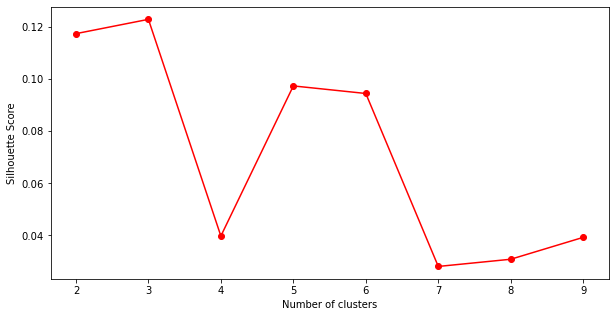

In [412]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score
max_score = 10
scores = []

for kclusters in range(2, max_score):
    # Run k-means clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 6).fit_predict(k_means_feed_scaled)
    
    # Gets the silhouette score
    score = silhouette_score(k_means_feed_scaled, kmeans)
    scores.append(score)

plt.figure(figsize=(10,5))
plt.plot(np.arange(2, max_score), scores, 'ro-')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.xticks(np.arange(2, max_score))
plt.show()

### K Means Clustering to generate Cluster Label

In [684]:
# import k-means from clustering stage
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 5

#ld_grouped_clustering = k_means_feed_scaled.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=11).fit(k_means_feed_scaled)

# check cluster labels generated for each row in the dataframe
kmeans.labels_


array([3, 1, 3, 0, 1, 3, 4, 3, 3, 1, 2, 3, 3, 3, 3, 1, 1, 3, 0, 3, 3, 3])

In [685]:
kmeans.labels_

array([3, 1, 3, 0, 1, 3, 4, 3, 3, 1, 2, 3, 3, 3, 3, 1, 1, 3, 0, 3, 3, 3])

* Cluster Labels are added to our DataFrame

In [687]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

ld_merged = ld_data

ld_merged = ld_merged.merge(neighborhoods_venues_sorted)

# FOLIUM MAP WITH CLUSTER LABELS

* Here we can see our cluster labels in action. A radius of 1km around each postal code location was used to show area of influence for each cluster.

In [688]:
np.linspace(10,1,10)

array([10.,  9.,  8.,  7.,  6.,  5.,  4.,  3.,  2.,  1.])

In [689]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.gnuplot2(np.linspace(0.2, 0.9, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ld_merged['Latitude'], ld_merged['Longitude'], ld_merged['Neighborhood'], ld_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.Circle(
        [lat, lon],
        radius=1000,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [690]:
ld_merged.head()

,Postal Code,City,Neighborhood,Price,Raw_Price,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,DA14,Sidcup,Frognal Avenue,"£3,593 pcm",3593,51.426481,0.105038,3,Pharmacy,Grocery Store,Coffee Shop,Fast Food Restaurant,Pizza Place,Café,Italian Restaurant,Supermarket,Hotel,Bakery
1,SE10,London,Cutter Lane Chandlers Avenue,"£2,990 pcm",2990,51.487122,0.003284,0,Grocery Store,Pier,Pub,Turkish Restaurant,Coffee Shop,Indian Restaurant,Pizza Place,Café,Japanese Restaurant,Mediterranean Restaurant
2,SE5,London,Lettsom Street,"£2,150 pcm",2150,51.481796,-0.090377,3,Park,Middle Eastern Restaurant,Coffee Shop,Café,Pub,Ethiopian Restaurant,Building,Garden,Italian Restaurant,Fish & Chips Shop
3,BR1,Bromley,Plaistow Lane,"£2,100 pcm",2100,51.401546,0.015415,1,Clothing Store,Coffee Shop,Gym / Fitness Center,Supermarket,Café,Chocolate Shop,Pub,Portuguese Restaurant,Pharmacy,Park
4,SE14,London,Childeric Road,"£1,900 pcm",1900,51.450352,0.062336,3,Mediterranean Restaurant,Department Store,Italian Restaurant,Portuguese Restaurant,Pub,Clothing Store,Movie Theater,Fast Food Restaurant,Pharmacy,Supermarket


In [691]:
#ld_merged.merge(new_df[['Neighborhood','Price','Raw_Price']]).head()

# NEIGHBORHOOD ANALYSIS

* Now let us look into our Neighborhoods in detail to try and figure out which one would best fit our requirements.

In [692]:
venue_count=ld_venues.groupby('Neighborhood')['Venue'].count().reset_index()
venue_count.rename(columns={'Venue':'Venue Count'},inplace=True)

* Combining data from different dataframes to create DataFrame for neighborhood data

In [693]:
nbr_data=ld_merged[['Neighborhood','Raw_Price','Cluster Labels']].merge(venue_count[['Neighborhood','Venue Count']])

In [694]:
nbr_data

,Neighborhood,Raw_Price,Cluster Labels,Venue Count
0,Frognal Avenue,3593,3,14
1,Cutter Lane Chandlers Avenue,2990,0,31
2,Lettsom Street,2150,3,18
3,Plaistow Lane,2100,1,36
4,Childeric Road,1900,3,14
5,New Wanstead,1800,1,25
6,Sherfield Gardens,1600,0,22
7,Adelaide Avenue,1450,3,44
8,Disraeli Road,1400,1,16
9,East Street,1400,3,6


# BUBBLE CHART
* Now we will generate a Bubble Chart by combining data for Raw_Price, Cluster Labels and Venue Count

In [695]:
import matplotlib.pyplot as plt
import plotly.express as px
  

plt.figure(figsize=(40,20)) 
fig = px.scatter(nbr_data, x="Neighborhood", y="Raw_Price",
                 color="Cluster Labels",
                 size='Venue Count', 
                 hover_data=['Venue Count'],
                 color_continuous_scale=px.colors.sequential.Rainbow
                 )
fig.update_layout(
    xaxis_title='Neighborhoods',
    yaxis_title='Rent Per Month')

fig.show()

<Figure size 2880x1440 with 0 Axes>

# CLUSTER ANALYSIS

* Now let us take a deeper look into the type of venues one can expect from each cluster

* First we will segment our ld_data based on Cluster Label.

In [696]:
cluster_data=ld_merged[['Neighborhood','Latitude','Longitude','Cluster Labels']]
cluster0=cluster_data[cluster_data['Cluster Labels']==0]
cluster1=cluster_data[cluster_data['Cluster Labels']==1]
cluster2=cluster_data[cluster_data['Cluster Labels']==2]
cluster3=cluster_data[cluster_data['Cluster Labels']==3]
cluster4=cluster_data[cluster_data['Cluster Labels']==4]

* Collecting all nearby venues for all neighborhoods in each Cluster

In [697]:
cluster0_venues = getNearbyVenues(names=cluster0['Neighborhood'],
                                   latitudes=cluster0['Latitude'],
                                   longitudes=cluster0['Longitude'])
cluster1_venues = getNearbyVenues(names=cluster1['Neighborhood'],
                                   latitudes=cluster1['Latitude'],
                                   longitudes=cluster1['Longitude'])
cluster2_venues = getNearbyVenues(names=cluster2['Neighborhood'],
                                   latitudes=cluster2['Latitude'],
                                   longitudes=cluster2['Longitude'])
cluster3_venues = getNearbyVenues(names=cluster3['Neighborhood'],
                                   latitudes=cluster3['Latitude'],
                                   longitudes=cluster3['Longitude'])
cluster4_venues = getNearbyVenues(names=cluster4['Neighborhood'],
                                   latitudes=cluster4['Latitude'],
                                   longitudes=cluster4['Longitude'])

Cutter Lane Chandlers Avenue
Sherfield Gardens
Plaistow Lane
New Wanstead
Disraeli Road
Anson Place
High Street South
Hoe Street
Frognal Avenue
Lettsom Street
Childeric Road
Adelaide Avenue
East Street
Jamaica Road
Sydenham Road
Sandford Road
Kingswood Estate
Shurland Gardens Willowbrook Estate
Grove Place
South Street
Kidman Close
Elmley Street


* One by one, we can see the type of Venues available in each catefory

### Type and number of venues available in Cluster 0

In [698]:
cluster0_venues['Venue Category'].value_counts()

Grocery Store               9
Pub                         5
Coffee Shop                 4
Pier                        3
Café                        3
Wine Shop                   2
Turkish Restaurant          2
Thai Restaurant             2
Indian Restaurant           2
Pizza Place                 2
Mediterranean Restaurant    1
South Indian Restaurant     1
Japanese Restaurant         1
English Restaurant          1
Brewery                     1
Metro Station               1
Irish Pub                   1
Pharmacy                    1
Warehouse Store             1
Recreation Center           1
Train Station               1
Gym / Fitness Center        1
Fish & Chips Shop           1
Italian Restaurant          1
Dim Sum Restaurant          1
Sandwich Place              1
Bakery                      1
Fast Food Restaurant        1
Music Venue                 1
Name: Venue Category, dtype: int64

### Type and number of venues available in Cluster 1

In [699]:
cluster1_venues['Venue Category'].value_counts()

Bus Stop                  11
Coffee Shop                8
Clothing Store             7
Pub                        7
Grocery Store              6
Supermarket                4
Park                       4
Convenience Store          3
Sandwich Place             3
Gym / Fitness Center       3
Chinese Restaurant         3
Café                       3
Bakery                     3
Fast Food Restaurant       3
Fried Chicken Joint        3
Pharmacy                   2
Bar                        2
Platform                   2
Electronics Store          2
Discount Store             2
Furniture / Home Store     2
Sushi Restaurant           1
Portuguese Restaurant      1
Thrift / Vintage Store     1
Newsstand                  1
Hungarian Restaurant       1
Department Store           1
Pizza Place                1
Malay Restaurant           1
Metro Station              1
Theater                    1
Concert Hall               1
Chocolate Shop             1
Recording Studio           1
Kebab Restaura

### Type and number of venues available in Cluster 2

In [700]:
cluster2_venues['Venue Category'].value_counts()

Coffee Shop                  5
Pub                          3
Clothing Store               2
Pizza Place                  2
Café                         2
Bakery                       2
Sandwich Place               2
Pharmacy                     2
Restaurant                   2
Convenience Store            1
Gym / Fitness Center         1
Bookstore                    1
Gift Shop                    1
Museum                       1
Indian Restaurant            1
Deli / Bodega                1
Sporting Goods Shop          1
Bar                          1
Tea Room                     1
Halal Restaurant             1
Farmers Market               1
Tapas Restaurant             1
Turkish Restaurant           1
Multiplex                    1
Electronics Store            1
Burger Joint                 1
Supermarket                  1
Middle Eastern Restaurant    1
Grocery Store                1
Health Food Store            1
Video Game Store             1
Caribbean Restaurant         1
Italian 

### Type and number of venues available in Cluster 3

In [701]:
cluster3_venues['Venue Category'].value_counts()

Pub                            15
Coffee Shop                    12
Café                            9
Bakery                          8
Clothing Store                  7
Supermarket                     7
Grocery Store                   7
Italian Restaurant              6
Pharmacy                        6
Park                            4
Train Station                   4
Pizza Place                     4
Japanese Restaurant             3
Fast Food Restaurant            3
Hotel                           3
Fish & Chips Shop               3
Shopping Mall                   2
Vietnamese Restaurant           2
Multiplex                       2
Video Game Store                2
Indian Restaurant               2
Mediterranean Restaurant        2
Platform                        2
Athletics & Sports              2
Gastropub                       2
Bar                             2
Gym / Fitness Center            2
Breakfast Spot                  2
Gift Shop                       2
Golf Course   

### Type and number of venues available in Cluster 4

In [702]:
cluster4_venues['Venue Category'].value_counts()

Clothing Store            6
Coffee Shop               6
Café                      5
Pub                       4
Shopping Mall             3
Grocery Store             3
Fast Food Restaurant      3
Supermarket               2
Bookstore                 2
American Restaurant       2
Italian Restaurant        2
Bar                       2
Bakery                    2
Pharmacy                  2
Multiplex                 1
Park                      1
English Restaurant        1
Hotel                     1
Chinese Restaurant        1
Department Store          1
Bowling Alley             1
Warehouse Store           1
Cosmetics Shop            1
Discount Store            1
Jewelry Store             1
Indoor Play Area          1
Restaurant                1
Platform                  1
Optical Shop              1
Plaza                     1
Sandwich Place            1
Brazilian Restaurant      1
Gym                       1
Furniture / Home Store    1
Pizza Place               1
Train Station       

* Top 10 venues for each neighborhood in Cluster 0

In [703]:
cluster0=ld_merged.loc[ld_merged['Cluster Labels'] == 0, ld_merged.columns[[1] + list(range(5, ld_merged.shape[1]))]]
cluster0

,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,London,51.487122,0.003284,0,Grocery Store,Pier,Pub,Turkish Restaurant,Coffee Shop,Indian Restaurant,Pizza Place,Café,Japanese Restaurant,Mediterranean Restaurant
6,London,51.564032,0.008813,0,Grocery Store,Coffee Shop,Café,Pub,Pizza Place,Fast Food Restaurant,Fish & Chips Shop,Dim Sum Restaurant,Metro Station,Thai Restaurant


* Top 10 venues for each neighborhood in Cluster 1

In [704]:
cluster1=ld_merged.loc[ld_merged['Cluster Labels'] == 1, ld_merged.columns[[1] + list(range(5, ld_merged.shape[1]))]]
cluster1

,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Bromley,51.401546,0.015415,1,Clothing Store,Coffee Shop,Gym / Fitness Center,Supermarket,Café,Chocolate Shop,Pub,Portuguese Restaurant,Pharmacy,Park
5,London,51.474867,-0.046933,1,Bus Stop,Platform,Convenience Store,Pub,Chinese Restaurant,Supermarket,Kebab Restaurant,Furniture / Home Store,Fried Chicken Joint,Electronics Store
8,London,51.453268,-0.032498,1,Coffee Shop,Fried Chicken Joint,Chinese Restaurant,Café,Bus Stop,Concert Hall,Malay Restaurant,Pub,Convenience Store,Theater
15,London,51.476810,-0.068163,1,Bus Stop,Discount Store,Pub,Grocery Store,Park,Supermarket,Coffee Shop,Fast Food Restaurant,Sandwich Place,Bus Station
17,London,51.537580,0.040295,1,Grocery Store,Market,Metro Station,Park,Pub,Sandwich Place,Fast Food Restaurant,Soccer Field,Pharmacy,Bakery


* Top 10 venues for each neighborhood in Cluster 2

In [705]:
cluster2=ld_merged.loc[ld_merged['Cluster Labels'] == 2, ld_merged.columns[[1] + list(range(5, ld_merged.shape[1]))]]
cluster2

,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,London,51.585503,-0.018014,2,Coffee Shop,Pub,Sandwich Place,Restaurant,Clothing Store,Pharmacy,Bakery,Pizza Place,Café,Portuguese Restaurant


* Top 10 venues for each neighborhood in Cluster 3

In [706]:
cluster3=ld_merged.loc[ld_merged['Cluster Labels'] == 3, ld_merged.columns[[1] + list(range(5, ld_merged.shape[1]))]]
cluster3

,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Sidcup,51.426481,0.105038,3,Pharmacy,Grocery Store,Coffee Shop,Fast Food Restaurant,Pizza Place,Café,Italian Restaurant,Supermarket,Hotel,Bakery
2,London,51.481796,-0.090377,3,Park,Middle Eastern Restaurant,Coffee Shop,Café,Pub,Ethiopian Restaurant,Building,Garden,Italian Restaurant,Fish & Chips Shop
4,London,51.450352,0.062336,3,Mediterranean Restaurant,Department Store,Italian Restaurant,Portuguese Restaurant,Pub,Clothing Store,Movie Theater,Fast Food Restaurant,Pharmacy,Supermarket
7,London,51.464123,-0.222848,3,Coffee Shop,Pub,Clothing Store,Café,Japanese Restaurant,Bakery,Grocery Store,Indian Restaurant,Sushi Restaurant,Italian Restaurant
9,Barking,51.554412,0.019655,3,Bakery,Bar,Pub,Restaurant,Flower Shop,Food Truck,Yoga Studio,Fried Chicken Joint,Donut Shop,Eastern European Restaurant
10,London,51.524785,0.078646,3,Diner,Eastern European Restaurant,Soccer Field,Multiplex,Dim Sum Restaurant,Discount Store,Donut Shop,Electronics Store,English Restaurant,Ethiopian Restaurant
11,London,51.491797,-0.042421,3,Pizza Place,Pharmacy,Supermarket,Pub,Vietnamese Restaurant,Platform,Gym,Clothing Store,Coffee Shop,American Restaurant
12,Bromley,51.429347,-0.044847,3,Supermarket,Pub,Gastropub,Breakfast Spot,Italian Restaurant,Café,Bakery,Park,English Restaurant,Electronics Store
13,London,51.407775,-0.003321,3,Home Service,Train Station,Golf Course,Fish & Chips Shop,Café,Furniture / Home Store,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant
14,London,51.434204,-0.085226,3,Garden Center,Bakery,Train Station,Gift Shop,Furniture / Home Store,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant


In [707]:
* Top 10 venues for each neighborhood in Cluster 4

,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,London,51.5776,0.178261,4,Coffee Shop,Clothing Store,Café,Pub,Grocery Store,Fast Food Restaurant,Shopping Mall,American Restaurant,Bookstore,Italian Restaurant


cluster4=ld_merged.loc[ld_merged['Cluster Labels'] == 4, ld_merged.columns[[1] + list(range(5, ld_merged.shape[1]))]]
cluster4

In [708]:
df_list = [cluster0_venues['Venue Category'] ,cluster1_venues['Venue Category'], cluster2_venues['Venue Category'], cluster3_venues['Venue Category'], cluster4_venues['Venue Category'],cluster4_venues['Venue Category']]


# BAR PLOTS

* We will utilise barplots to conduct two studies:
* Comparison of number of Venues available in each Cluster
* Comparison of probability of finding a particular venue in each Cluster.(This is used to provide a more objective approach to compare clusters with high venue counts to those with low venue counts.)

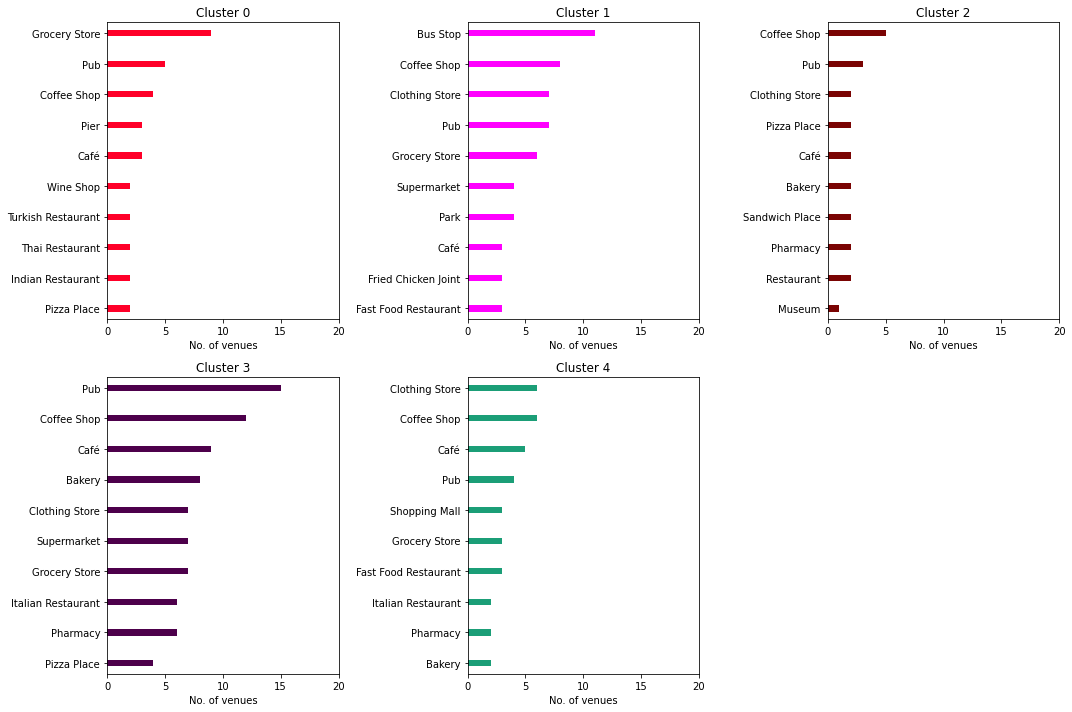

In [709]:
import matplotlib.pyplot as plt
import numpy as np
fig=plt.figure(figsize=(10,7))
columns = 3
rows = 2
colormaps=['gist_rainbow', 'spring', 'turbo_r', 'BuPu_r', 'Dark2']
a=np.random.rand(2,3)
for i in range(1,6):
    fig.add_subplot(rows, columns, i)
    df_list[i-1].value_counts().sort_values().tail(10).plot.barh( width=0.2, figsize=(15,10),colormap=colormaps[i-1])### what you want you can plot
    plt.title('Cluster {}'.format(i-1))  
    plt.xticks(np.arange(0, 25, 5))
    plt.xlabel('No. of venues')
fig.tight_layout()
plt.show()

* From the graph above we can see the type and number of venues one can come across if they stay in a particular cluster.

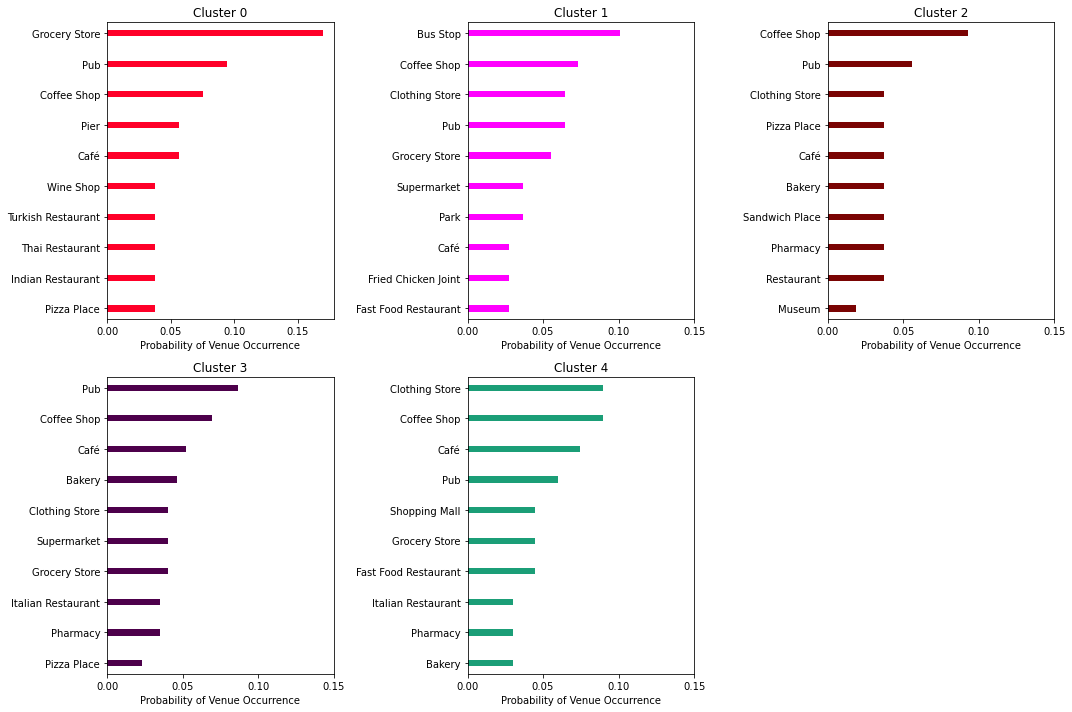

In [710]:
import matplotlib.pyplot as plt
import numpy as np
fig=plt.figure(figsize=(10,7))
columns = 3
rows = 2
a=np.random.rand(2,3)
colormaps=['gist_rainbow', 'spring', 'turbo_r', 'BuPu_r', 'Dark2']
for i in range(1,6):
    fig.add_subplot(rows, columns, i)
    df_list[i-1].value_counts(normalize=True).sort_values().tail(10).plot.barh( width=0.2, figsize=(15,10),colormap=colormaps[i-1])### what you want you can plot
    plt.title('Cluster {}'.format(i-1)) 
    plt.xticks(np.arange(0, .20,0.05)) 
    plt.xlabel('Probability of Venue Occurrence')
fig.tight_layout()
plt.show()

* From the graph above we can see the average probabilty of coming across certain venues if the person is staying in a location within these clusters.(Taking Venue Count density into account)